In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras

In [2]:
model = keras.models.load_model('dino_dragon_10_0.899.h5')

In [3]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('dino_dragon.tflite', 'wb')as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\daver\AppData\Local\Temp\tmpkuimjo5s\assets


In [4]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 061A-7F5F

 Directory of C:\Users\daver\Desktop\DataScience\zoomcamp\Week_9\homework

11/28/2022  08:07 AM    <DIR>          .
11/27/2022  10:16 PM    <DIR>          ..
11/28/2022  02:31 AM    <DIR>          .ipynb_checkpoints
11/29/2022  09:34 PM        44,865,888 dino_dragon.tflite
11/23/2022  06:42 AM        89,759,168 dino_dragon_10_0.899.h5
11/28/2022  08:07 AM            82,018 Week_9_homework.ipynb
               3 File(s)    134,707,074 bytes
               3 Dir(s)  153,713,168,384 bytes free


## Answer Question 1: 43 Mb

In [5]:
import tensorflow.lite as tflite

In [6]:
interpreter = tflite.Interpreter(model_path='dino_dragon.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [7]:
output_index

13

## Answer Question 2: 13

In [8]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

In [9]:
img = download_image('https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg')

In [10]:
img = prepare_image(img, target_size=(150,150))

C:\Users\daver\AppData\Local\Temp\ipykernel_33360\2487457277.py:17: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.resize(target_size, Image.NEAREST)


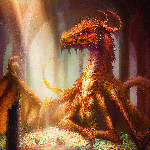

In [11]:
img

In [12]:
def preprocess_input(x):
    return x / 255.0

In [13]:
import numpy as np
x = np.array(img, dtype='float32')
X = np.array([x])

X = preprocess_input(X)

In [14]:
X[0, 0, 0, 0]

0.5529412

## Answer Question 3: 0.5529412

In [15]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()

preds = interpreter.get_tensor(output_index)

In [16]:
preds

array([[0.82448614]], dtype=float32)

## Answer Question 4: 0.82448614

In [17]:
classes = ['dragon', 'dino']
dict(zip(classes, preds[0]))

{'dragon': 0.82448614}

## All together

In [1]:
import tensorflow.lite as tflite
import numpy as np

from io import BytesIO
from urllib import request

from PIL import Image

In [2]:
interpreter = tflite.Interpreter(model_path='dino_dragon.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [3]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

In [38]:
img = download_image('https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg')
#img = download_image('https://res.cloudinary.com/dk-find-out/image/upload/q_80,w_1920,f_auto/MonolophosaurusHiRes_usl6ti.jpg')

In [39]:
img = prepare_image(img, target_size=(150,150))

C:\Users\daver\AppData\Local\Temp\ipykernel_31848\2487457277.py:17: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.resize(target_size, Image.NEAREST)


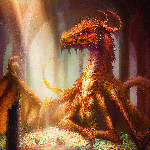

In [40]:
img

In [41]:
def preprocess_input(x):
    return x / 255.0

In [42]:
import numpy as np
x = np.array(img, dtype='float32')
X = np.array([x])

X = preprocess_input(X)

In [43]:
classes = ['dragon', 'dino']

In [44]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()

preds = interpreter.get_tensor(output_index)

In [45]:
if preds > 0.5:
    print("Prediction for Dragon:", preds, "Therefore it is a Dragon")
else:
    print("Prediction for Dragon:", preds, "Therefore it is a Dinosaur")

Prediction for Dragon: [[0.82448614]] Therefore it is a Dragon


## Files

### DockerFile

    FROM public.ecr.aws/lambda/python:3.9
    FROM svizor42/zoomcamp-dino-dragon-lambda:v2

    RUN pip install keras-image-helper
    RUN pip install https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.7.0-cp39-cp39-linux_x86_64.whl

    COPY lambda_function.py .

    ENV MODEL_NAME=dino-vs-dragon-v2.tflite

    CMD [ "lambda_function.lambda_handler" ]

### lambda_function.py

    import tflite_runtime.interpreter as tflite
    import numpy as np

    import os

    from io import BytesIO
    from urllib import request

    from PIL import Image

    MODEL_NAME = os.getenv('MODEL_NAME', 'dino-vs-dragon-v2.tflite')

    def download_image(url):
        with request.urlopen(url) as resp:
            buffer = resp.read()
        stream = BytesIO(buffer)
        img = Image.open(stream)
        return img


    def prepare_image(img, target_size):
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize(target_size, Image.NEAREST)
        return img


    def prepare_input(x):
        return x / 255.0

    interpreter = tflite.Interpreter(model_path=MODEL_NAME)
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']


    classes = ['dragon', 'dino']


    def predict(url):
        img = download_image(url)
        img = prepare_image(img, target_size=(150, 150))

        x = np.array(img, dtype='float32')
        X = np.array([x])

        X = prepare_input(X) 

        interpreter.set_tensor(input_index, X)
        interpreter.invoke()
        preds = interpreter.get_tensor(output_index)

        # We have to convert the numpy array to a python array with numpy floats
        float_predictions = preds[0].tolist()

        #return dict(zip(classes, float_predictions))

        return float_predictions

    def lambda_handler(event, context):
        url = event['url']
        result = predict(url)
        return result

### test.py

    import requests

    url = 'http://localhost:8080/2015-03-31/functions/function/invocations'

    data = {'url': 'https://upload.wikimedia.org/wikipedia/en/e/e9/GodzillaEncounterModel.jpg'}

    result = requests.post(url, json=data).json()

    print(result)

## Command line

    docker build -t dino_dragon .
    docker run -it --rm -p 8080:8080 dino_dragon:latest
    python test.py

## Results

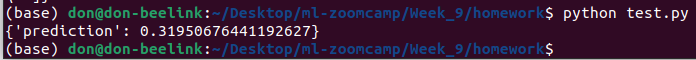